# Nationwide Diversity and Integration

This notebook pulls together the main features of the `censusdis` and
`divintseg` projects to demonstrate how quickly and easily we can 

1. Identify US Census data variables. 
    - We will use metadata calls to identify 16 race and ethnicity variables.
2. Download the variables for the entire country at the block group level. 
    - There are almost 240,000 census block groups in the 50 states and DC.
    - We will download all 16 variables for all of them
3. Compute diversity and integration metrics at the census tract level.
    - There are over 84,000 census tracts in the 50 states and DC.
    - Integration expresses how integrated the block groups within a tract are.
4. Attach geography bounds to all the census tracts.
    - This process will transparently download and cache census map data
      on a state by state basis. 
    - `censusdis` will determine how to do this
      and manage the process. No user input is required.
5. Download state boundaries.
    - This is simply to make our final maps look better.
6. Plot maps showing nationwide diversity and integration.
    - Data is plotted at the census tract level
    - Alaska and Hawaii are automatically relocated on the map to better use output real estate
    - The state boundaries are plotted to make the maps more readable.
    
Even in a fresh python environment with no data pre-cached locally, this entire process can
be run on a fairly standard laptop with a high-speed internet connection in a jsut a few minutes.

For more details, please refer to the README files and other documentation in the 
[`censusdis`](https://github.com/vengroff/censusdis) 
and 
[`divintseg`](https://github.com/vengroff/divintseg)
projects.

## 0. Imports and configuration

In [1]:
# So we can run from within the censusdis project and find the packages we need.
import os
import sys

sys.path.append(
    os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)))
)

In [2]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import ALL_STATES_AND_DC

import divintseg as dis

In [3]:
# Fill in your own key here, or leave as is 
# if you are doing low volume queries that
# will not hit the census server usage limits.
CENSUS_API_KEY = None

## 1. Identify the dataset and variables we will use

In [4]:
DATASET = "acs/acs5"
YEAR = 2020

In [5]:
GROUP = "B03002"

In [6]:
leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

In [7]:
len(leaves)

16

## 2. Download the data

In [8]:
%%time

df_bg = ced.download_detail(
    DATASET,
    YEAR,
    leaves,
    state=ALL_STATES_AND_DC,
    block_group="*",
    api_key=CENSUS_API_KEY,
)

CPU times: user 1.39 s, sys: 188 ms, total: 1.58 s
Wall time: 17.8 s


In [9]:
df_bg.shape

(239780, 20)

## 3. Compute diversity and integration

In [10]:
%%time

df_di = dis.di(
    df_bg,
    by=["STATE", "COUNTY", "TRACT"],
    over="BLOCK_GROUP",
).reset_index()

CPU times: user 1min 1s, sys: 425 ms, total: 1min 1s
Wall time: 1min 2s


In [11]:
df_di.shape

(84414, 5)

## 4. Infer the geographies so we can plot

In [12]:
%%time

gdf_di = ced.add_inferred_geography(df_di, YEAR)

CPU times: user 2.95 s, sys: 88.6 ms, total: 3.04 s
Wall time: 3.04 s


## 5. Get state boundaries for the plots

In [13]:
%%time 

gdf_states = cem.ShapeReader(year=YEAR).read_cb_shapefile("us", "state")

gdf_states = gdf_states[gdf_states.STATEFP.isin(ALL_STATES_AND_DC)]

CPU times: user 65.4 ms, sys: 3.4 ms, total: 68.8 ms
Wall time: 68.2 ms


## 6. Plot diversity and integration

CPU times: user 19.8 s, sys: 168 ms, total: 20 s
Wall time: 19 s


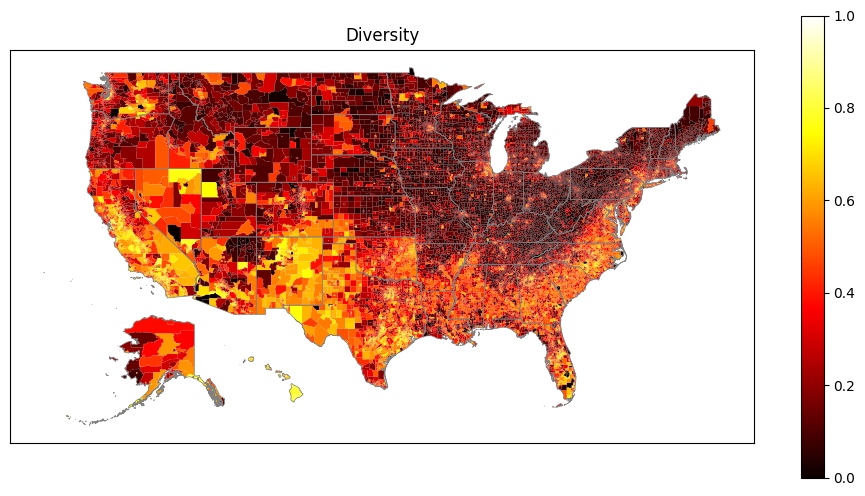

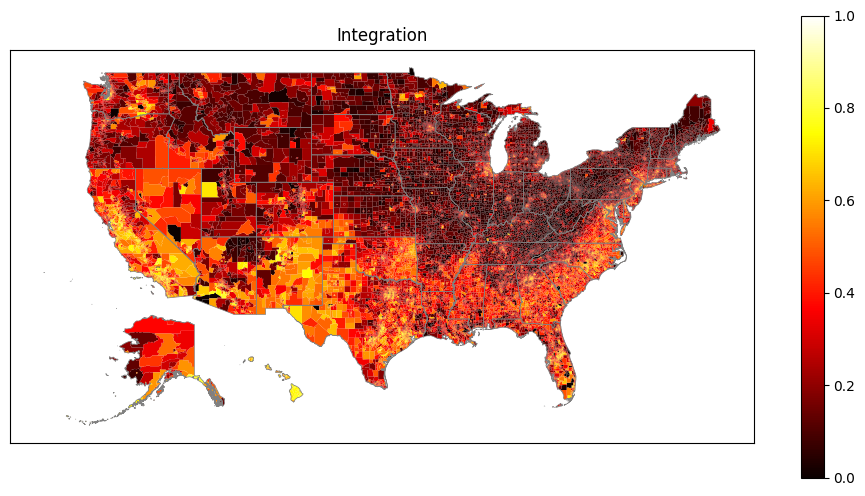

In [14]:
%%time

for col in ['diversity', 'integration']:
    ax = cem.plot_us(
        gdf_di[gdf_di.geometry != None],
        col,
        cmap="hot",
        legend=True,
        figsize=(12, 6),
        vmin=0.0,
        vmax=1.0,
    )

    ax = cem.plot_us_boundary(
        gdf_states,
        edgecolor="gray",
        linewidth=0.5,
        ax=ax
    )
    
    ax.set_title(col.title())

    ax.tick_params(
        left=False,
        right=False,
        bottom=False,
        labelleft=False,
        labelbottom=False,
    )